# **Modele de prediction d'un defaut de Credit**

# Chargement de donnees

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
data = pd.read_csv('Datasets/UCI_Credit_Card.csv',index_col='ID')
data.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
# Les types des donnees
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   30000 no

In [5]:
# Valeurs manquantes
data.isna().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

**Le dataset ne contient pas de valeur manquantes**

In [6]:
# Renommer la classe a predire
data = data.rename(columns={'default.payment.next.month':'y'})


In [7]:
print("Effectif de la premiere classe",data[data['y']==0].shape[0])
print("Effectif de la deuxieme classe",data[data['y']==1].shape[0])

Effectif de la premiere classe 23364
Effectif de la deuxieme classe 6636


**La sous representativite de la deuxieme classe peux etre source de probleme 
au moment de la classification**

# Visualisation

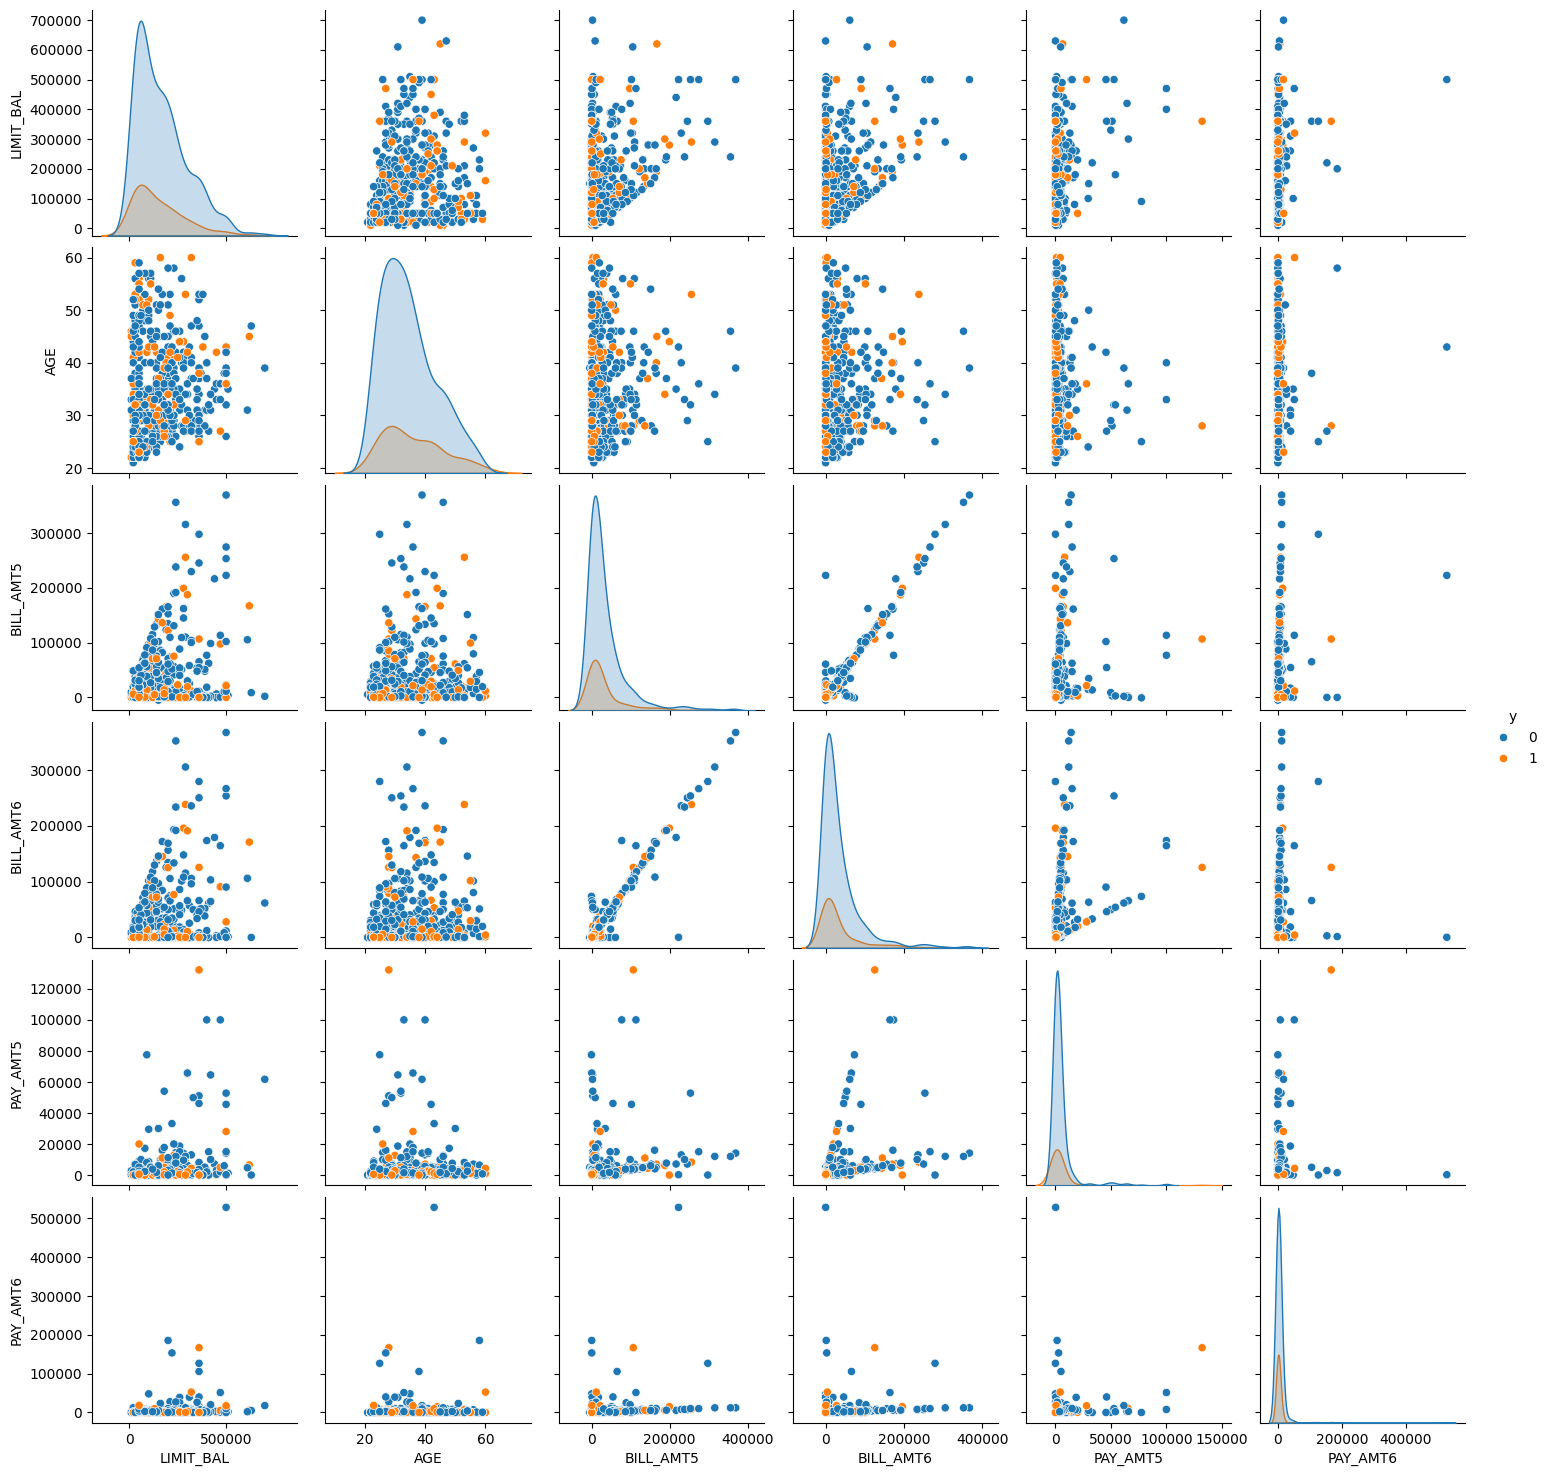

In [8]:
donnee = data.drop(['SEX','EDUCATION','MARRIAGE','PAY_0',
                                     'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4',
                                     'PAY_AMT1','PAY_AMT2',"PAY_AMT3",'PAY_AMT4'],axis=1)
sns.pairplot(hue="y",data=donnee[500:1000])

# Pretraitement des donnees

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,QuantileTransformer,PolynomialFeatures
from sklearn.metrics import confusion_matrix,classification_report
import xgboost as xgb
from sklearn.svm import SVC

In [10]:
X = data.drop('y',axis=1)
y = data['y'].values.reshape(-1,1)

print('La taille des features',X.shape)
print('La taille de y',y.shape)

La taille des features (30000, 23)
La taille de y (30000, 1)


# **Pipeline**

# *Regression Logistique*

In [11]:
data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'y'],
      dtype='object')

In [12]:
# Train et Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# Colonnes
numeric_columns = data.columns.drop(['SEX','EDUCATION','MARRIAGE','PAY_0',
                                     'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','y'])
categorical_columns = [ 'SEX','EDUCATION', 'MARRIAGE','PAY_0','PAY_2','PAY_3',
                       'PAY_4','PAY_5','PAY_6']

# Prétraitement X
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('num2',QuantileTransformer(),numeric_columns),
   #('num3',PolynomialFeatures(degree=2),numeric_columns),
   ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
])

# Pipeline avec Logistic Regression
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])


In [13]:
# Entrainement du modele
pipe.fit(X_train,y_train)
# Evaluation du modele
print("Le score sur l'ensemble d'entrainement est :",pipe.score(X_train,y_train))
print("Le score sur les donnees test :",pipe.score(X_test,y_test))
print(classification_report(y_test,pipe.predict(X_test)))

c:\Users\Ezae V2\Python_vscode\myvenv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Le score sur l'ensemble d'entrainement est : 0.8221666666666667
Le score sur les donnees test : 0.8168333333333333
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4698
           1       0.66      0.33      0.44      1302

    accuracy                           0.82      6000
   macro avg       0.75      0.64      0.66      6000
weighted avg       0.80      0.82      0.79      6000



## **Interpretation**
On remarque que le desequilibre des classes dans le jeu de donnee a un impact sur la classification.
Le modele est beaucoup moins efficace dans la classification des individus de la classe '1'.

# *Foret Aleatoire*

In [ ]:
pipe1 = Pipeline([
    ('preprocessor', preprocessor),
    ('model',RandomForestClassifier() )
])

In [15]:
# ENtrainement du modele
pipe1.fit(X_train,y_train)
# Evaluation du modele
print("Le score sur l'ensemble d'entrainement est :",pipe1.score(X_train,y_train))
print("Le score sur l'ensemble test :",pipe1.score(X_test,y_test))
print(classification_report(y_test,pipe1.predict(X_test)))

c:\Users\Ezae V2\Python_vscode\myvenv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Le score sur l'ensemble d'entrainement est : 0.9993333333333333
Le score sur l'ensemble test : 0.8138333333333333
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4698
           1       0.63      0.34      0.44      1302

    accuracy                           0.81      6000
   macro avg       0.73      0.64      0.67      6000
weighted avg       0.79      0.81      0.79      6000



**Meme constat que pour le modele precedent**

# **Prediction**

In [54]:
def prediction(LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,
       PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,
       BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,
       PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6):
   
    new = pd.DataFrame([{'LIMIT_BAL':LIMIT_BAL,'SEX':SEX, 'EDUCATION':EDUCATION, 'MARRIAGE':MARRIAGE,
                         'AGE':AGE, 'PAY_0':PAY_0, 'PAY_2':PAY_2,
       'PAY_3':PAY_3, 'PAY_4':PAY_4, 'PAY_5':PAY_5, 'PAY_6':PAY_6,
       'BILL_AMT1':BILL_AMT1, 'BILL_AMT2':BILL_AMT2,
       'BILL_AMT3':BILL_AMT3, 'BILL_AMT4':BILL_AMT4, 'BILL_AMT5':BILL_AMT5,
       'BILL_AMT6':BILL_AMT6, 'PAY_AMT1':PAY_AMT1,
       'PAY_AMT2':PAY_AMT2, 'PAY_AMT3':PAY_AMT3, 'PAY_AMT4':PAY_AMT4, 
       'PAY_AMT5':PAY_AMT5, 'PAY_AMT6':PAY_AMT6
      }])
    # print(new)
    a = pipe1.predict_proba(new)
    print("La probabilite de la classification",pipe1.predict_proba(new))
    y_pred = pipe1.predict(new)
    if y_pred==1:
          print(f'Le client aura un defaut de credit avec un niveau de confiance de {a[0][1] * 100} %')
    else:
      print(f"Le client n'aura pas un defaut de credit avec un niveau de confiance de {a[0][0] * 100} % ")      
      
    return 

In [69]:
prediction(50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000)

La probabilite de la classification [[0.95 0.05]]
Le client n'aura pas un defaut de credit avec un niveau de confiance de 95.0 % 


In [70]:
# Gestion du desequilibre des classes

In [71]:
from imblearn.over_sampling import SMOTE

# Oversample the minority class using SMOTE
oversampler = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)
print('Taille avant',y_train.shape)
print("Taille apres equilibrage du dataset",y_train_oversampled.shape)
# Colonnes
numeric_columns = data.columns.drop(['SEX','EDUCATION','MARRIAGE','PAY_0',
                                     'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','y'])
categorical_columns = [ 'SEX','EDUCATION', 'MARRIAGE','PAY_0','PAY_2','PAY_3',
                       'PAY_4','PAY_5','PAY_6']

# Prétraitement X
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('num2',QuantileTransformer(),numeric_columns),
   #('num3',PolynomialFeatures(degree=2),numeric_columns),
   ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
])

# Pipeline avec Logistic Regression
pipe2 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])



Taille avant (24000, 1)
Taille apres equilibrage du dataset (37332,)


In [72]:
# ENtrainement du modele
pipe2.fit(X_train_oversampled,y_train_oversampled)
# Evaluation du modele
print("Le score sur l'ensemble d'entrainement est :",pipe2.score(X_train_oversampled,y_train_oversampled))
print("Le score sur l'ensemble test :",pipe2.score(X_test,y_test))
print(classification_report(y_test,pipe2.predict(X_test)))

Le score sur l'ensemble d'entrainement est : 0.9993303332261867
Le score sur l'ensemble test : 0.7755
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4698
           1       0.48      0.45      0.46      1302

    accuracy                           0.78      6000
   macro avg       0.67      0.66      0.66      6000
weighted avg       0.77      0.78      0.77      6000



**On a donc ameliorer legerement la qualite de la classification pour la classe'1'**